In [1]:
import numpyro
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, DiscreteHMCGibbs

from jax import numpy as jnp
from jax import random

import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az

from dfply import *

import pickle

%run -i 'model_helpers.py'
%run -i 'models.py'
%run -i 'reloo-compare.py'

In [33]:
def load_data_exp1_trials():
    df = load_raw_data(1)
    # df["condition"] = np.select([df.querydetail.str.contains("icy|frosty")],[0], default=0)
    df = df >> s.mutate(condition = s.if_else(df.querydetail.str.contains("icy|frosty"), 0, 1))
    
    original_ids = list(np.unique(df.ID))
    fix_id_dict = {original_ids[i]:i for i in range(0, len(original_ids))}
    
    df = df.assign(ID = df.ID.apply(lambda x: fix_id_dict[x]))

    return df


# >>
#         s.mutate(estimate =  _.estimate.replace({0:.01, 1:.99}))

In [34]:
df = load_data_exp1_trials() # see data_helpers.py
# df = df[df["condition"]!=2] # filter out "warm/snowy" as per paper
# df = df.sort_values(by=["ID","block","condition"]) # don't think I need to sort?

df = (df >> 
      # s.mutate(block = _.block-1) >> 
      s.filter(_.block==1) >>
      # s.group_by(_.ID, _.condition, _.querytype, _.querydetail) >> 
      # s.summarize(estimate = _.estimate.mean()) >>
      s.mutate(estimate =  _.estimate.replace({0:.01, 1:.99}))
     )

df.head(20)


,ID,block,trial,query,querydetail,querytype,estimate,starttime,endtime,RT,condition
0,0,1,1,What is the probability that the weather will ...,not frosty,notB,0.60,1.122868e+06,1.122878e+06,9.729185,0
1,0,1,2,If the weather in England is normal on a rando...,typical given normal,BgA,0.50,1.122878e+06,1.122893e+06,14.901229,1
2,0,1,3,What is the probability that the weather will ...,normal,A,0.50,1.122893e+06,1.122903e+06,9.686761,1
3,0,1,4,What is the probability that the weather will ...,not icy or not frosty,notAornotB,0.50,1.122903e+06,1.122911e+06,7.788618,0
4,0,1,5,If the weather in England is normal on a rando...,not typical given normal,notBgA,0.70,1.122911e+06,1.122920e+06,8.626205,1
5,0,1,6,What is the probability that the weather will ...,typical and not normal,notAandB,0.72,1.122920e+06,1.122928e+06,8.634105,1
6,0,1,7,What is the probability that the weather will ...,icy,A,0.45,1.122929e+06,1.122947e+06,18.779673,0
7,0,1,8,What is the probability that the weather will ...,not typical,notB,0.50,1.122947e+06,1.122954e+06,6.264562,1
8,0,1,9,What is the probability that the weather will ...,normal or not typical,AornotB,0.65,1.122954e+06,1.122965e+06,11.073752,1
9,0,1,10,What is the probability that the weather will ...,normal or typical,AorB,0.59,1.122965e+06,1.122984e+06,18.809799,1


In [35]:
X_data, y_data = make_model_data(df) # see data_helpers.py

print(len(y_data), "observations")

2360 observations


# Bayesian sampler model

Here I implement the Bayesian Sampler model as expressed in the Zhu et al. (2020) paper. The only difference is I parameterize it directly in terms of implied $d$ so that it can be more fairly compared with the PT+N model. 

## Simple

First, I implement the simple model with only one $d$ value for each participant. Here implied $d \in [0,\frac{1}{3}]$, reflecting the class of "ignorance priors" for the underlying Bayesian Sampler model.

In [5]:
## -------------------------------------
## Bayesian Sampler
## -------------------------------------

def prob_judge_BS(theta, X_num, X_denom, N, beta):

    pi = calc_prob(theta, X_num, X_denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
    
    return p_bs

def prob_judge_BS_d(theta, X_num, X_denom, d):

    pi = calc_prob(theta, X_num, X_denom)
    return calc_ptn_prob(pi, d)


def bayesian_sampler_simple(data, y=None):

    # Data processing
    trial, subj, cond= data["trial"], data["subj"], data["cond"]#, data["block"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0]#, np.unique(block).shape[0]
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    not_conjdisj = abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    # subject-level parameters/priors 
#    with numpyro.plate("subj", n_Ps):
#        betas = numpyro.sample("beta", dist.Uniform(0.0, 1.0)) # bounded to [0,1] as in paper
#        Ns = numpyro.sample("N_prime", dist.Normal(0,3))

    with numpyro.plate("subj", n_Ps):
#        ds = numpyro.sample("d_base", dist.Beta(1, 1))
        ds = numpyro.sample("d_base", dist.Normal(0, 1.75))
        
    # subject/query-level parameters/priors (vary by subject and query but not block)
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
#    beta = betas[subj] # use jnp.exp() if unbounded
    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
    
    d_lin = ds[subj]
    d = sigmoid(d_lin)/3.
#    N_lin = Ns[subj] #  < --------------     
#    N = 1 + jnp.exp(N_lin) # they required N be at least 1
    
    p_bs = prob_judge_BS_d(theta, X_num, X_denom, d)
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
    return yhat



In [106]:
kernel_bs_simple = NUTS(bayesian_sampler_simple, target_accept_prob=.80)

mcmc_bs_simple = MCMC(kernel_bs_simple, 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)

mcmc_bs_simple.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [110]:
# mcmc_bs_simple.print_summary()

Participant mean response corr =  0.549
Query-level corr 0.844


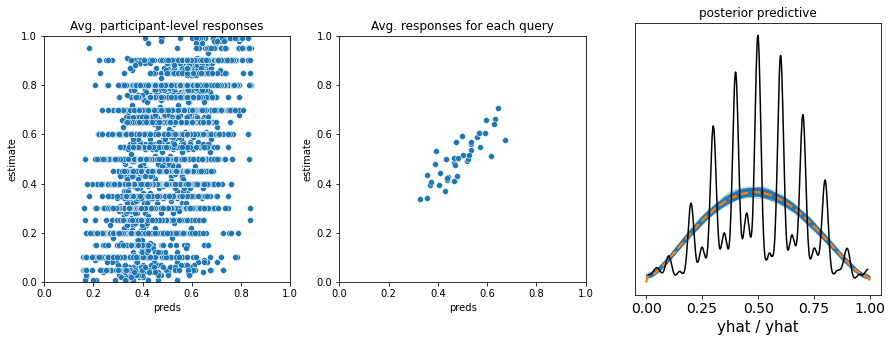

In [108]:
az_data_bs_simple = make_arviz_data(mcmc_bs_simple, bayesian_sampler_simple, X_data) # see model_helpers.py
plot_model_preds(df, az_data_bs_simple)

In [11]:
loo_bs_simple = model_reloo(mcmc_bs_simple, kernel_bs_simple, k_thresh=.70)

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats_refitting.py:99: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [12]:
# pickle.dump(az_data_bs_simple, open("local/exp2/az_data_bs_simple.p", "wb"))
# pickle.dump(loo_bs_simple, open("local/exp2/loo_bs_simple.p", "wb"))

## Parameterized in terms of $\beta$ and $N$

Now parameterized as needed for modeling dispersion.

N and beta are going to be potentially very highly correlated here. -- fortunately it sampled with no divergences!

In [113]:
def bayesian_sampler_simple2(data, y=None):

    # Data processing
    trial, subj, cond= data["trial"], data["subj"], data["cond"]#, data["block"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0]#, np.unique(block).shape[0]
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    not_conjdisj = abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    # subject-level parameters/priors 
#    with numpyro.plate("subj", n_Ps):
#        betas = numpyro.sample("beta", dist.Uniform(0.0, 1.0)) # bounded to [0,1] as in paper
#        Ns = numpyro.sample("N_prime", dist.Normal(0,3))

    with numpyro.plate("subj", n_Ps):
#        ds = numpyro.sample("d_base", dist.Beta(1, 1))
        # ds = numpyro.sample("d_base", dist.Normal(0, 1.75))
        betas = numpyro.sample("beta_base", dist.Beta(1,1))
        Ns = numpyro.sample("N_base", dist.HalfCauchy(10))
        
    # subject/query-level parameters/priors (vary by subject and query but not block)
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
#    beta = betas[subj] # use jnp.exp() if unbounded
    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
    
    # d_lin = ds[subj]
    N = 1. + Ns[subj]
    beta = betas[subj]
    # d = sigmoid(d_lin)/3.
#    N_lin = Ns[subj] #  < --------------     
#    N = 1 + jnp.exp(N_lin) # they required N be at least 1
    
    p_bs = prob_judge_BS(theta, X_num, X_denom, N, beta)
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
    return yhat



In [114]:
kernel_bs_simple2 = NUTS(bayesian_sampler_simple2, target_accept_prob=.80)

mcmc_bs_simple2 = MCMC(kernel_bs_simple2, 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)

mcmc_bs_simple2.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [122]:
# mcmc_bs_simple2.print_summary()

Participant mean response corr =  0.548
Query-level corr 0.838


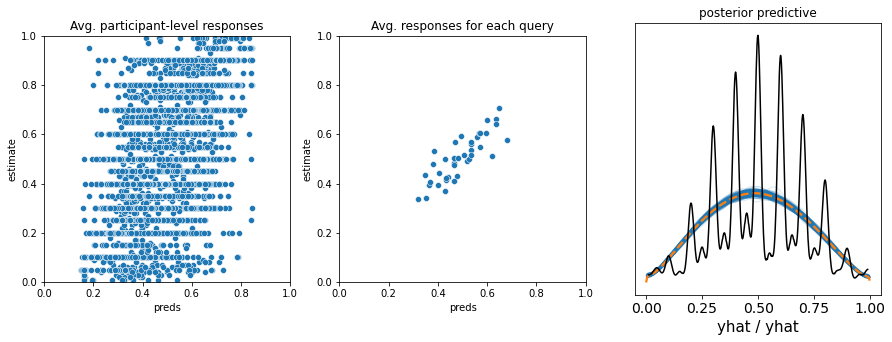

In [118]:
az_data_bs_simple2 = make_arviz_data(mcmc_bs_simple2, bayesian_sampler_simple2, X_data) # see model_helpers.py
plot_model_preds(df, az_data_bs_simple2)

# Hierarchical Bayesian Sampler

Unpooled models may be overpenalized for complexity if the heterogenity among participants is actually low. Here I implement hierarchical versions of the PT+N and Bayesian Sampler models that impelement partial pooling. This allows for sharing of information and potentially reduced model complexity.


## Complex

Here's the complex version in its original parameterization

In [36]:

def bayesian_sampler_complex_mlm(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 

    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter
    beta_pop = numpyro.sample("beta_pop", dist.Normal(-2, 1)) # roughly uniform after summing with random effects + sigmoid()
    beta_sd = numpyro.sample("beta_sd", dist.HalfCauchy(1))

    N_prime_pop = numpyro.sample("N_prime_pop", dist.Normal(0,2)) # mildly informative
    N_delta_pop = numpyro.sample("N_delta_pop", dist.Normal(0,2)) 
    N_prime_sd = numpyro.sample("N_prime_sd", dist.HalfCauchy(2))
    N_delta_sd = numpyro.sample("N_delta_sd", dist.HalfCauchy(2))

    # subject-level parameters/priors <--- maybe change to non-centered parameterization for all these
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta_r", dist.Normal(0, beta_sd)) 
        N_deltas = numpyro.sample("N_delta_r", dist.Normal(0, N_delta_sd))
        N_primes = numpyro.sample("N_prime_r", dist.Normal(0, N_prime_sd))

    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))

    beta = sigmoid(beta_pop + betas[subj])*10 # constrains beta to [0,10]
    #beta = jnp.exp(beta_pop + betas[subj])
    numpyro.deterministic("beta_subj", jnp.exp(beta_pop + betas))

    # exp() needed to constrain N and N_delta positive
    N = 1 + jnp.exp(N_prime_pop + N_primes[subj]) + jnp.exp(N_delta_pop + N_deltas[subj]) * not_conjdisj # they also required N be at least 1

    numpyro.deterministic("N_subj", 1 + jnp.exp(N_prime_pop + N_primes))
    numpyro.deterministic("N_prime_subj", 1 + jnp.exp(N_prime_pop + N_primes) + jnp.exp(N_delta_pop + N_deltas))

    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]

    p_bs = prob_judge_BS(theta, X_num, X_denom, N, beta)

    # Likelihood
    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)

    return yhat

In [37]:
kernel_bs = NUTS(bayesian_sampler_complex_mlm, target_accept_prob=.80)

mcmc_bs = MCMC(kernel_bs, 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4
              )

mcmc_bs.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [40]:
# loo_bs = model_reloo(mcmc_bs, kernel_bs, k_thresh=.70)

mcmc_bs.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  N_delta_pop      0.76      0.30      0.77      0.29      1.25   1409.71      1.00
 N_delta_r[0]     -0.06      0.47     -0.03     -0.87      0.65   2688.41      1.00
 N_delta_r[1]     -0.12      0.47     -0.07     -0.89      0.63   2307.06      1.00
 N_delta_r[2]     -0.09      0.47     -0.05     -0.84      0.64   3001.67      1.00
 N_delta_r[3]      0.00      0.47      0.00     -0.76      0.74   4244.73      1.00
 N_delta_r[4]      0.04      0.49      0.02     -0.76      0.82   2235.28      1.00
 N_delta_r[5]      0.08      0.49      0.04     -0.74      0.81   1705.57      1.00
 N_delta_r[6]     -0.13      0.47     -0.06     -0.92      0.58   1653.45      1.00
 N_delta_r[7]     -0.15      0.48     -0.08     -0.89      0.57   1352.94      1.00
 N_delta_r[8]      0.09      0.48      0.04     -0.69      0.85   2764.53      1.00
 N_delta_r[9]      0.05      0.47      0.02     -0.67      0.81   2262.16  

Participant mean response corr =  0.706
Query-level corr 0.869


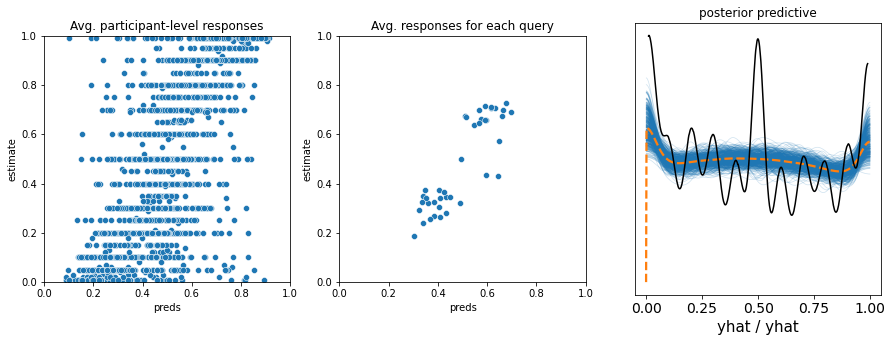

In [8]:
az_data_bs = make_arviz_data(mcmc_bs, bayesian_sampler_complex_mlm, X_data) # see model_helpers.py
# pickle.dump(az_data_bs, open("local/exp2/az_data_bs.p", "wb"))
# pickle.dump(loo_bs, open("local/exp2/loo_bs.p", "wb"))
plot_model_preds(df, az_data_bs)

## Varying noise parameters



In [28]:

def bayesian_sampler_complex_mlm_noise(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 

    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    # k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter
    beta_pop = numpyro.sample("beta_pop", dist.Normal(-2.75, .9)) # skewed after sigmoid
    beta_sd = numpyro.sample("beta_sd", dist.HalfCauchy(1))

    N_prime_pop = numpyro.sample("N_prime_pop", dist.Normal(0,2)) # mildly informative
    N_delta_pop = numpyro.sample("N_delta_pop", dist.Normal(0,2)) 
    N_prime_sd = numpyro.sample("N_prime_sd", dist.HalfCauchy(2))
    N_delta_sd = numpyro.sample("N_delta_sd", dist.HalfCauchy(2))

    # subject-level parameters/priors <--- maybe change to non-centered parameterization for all these
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta_r", dist.Normal(0, beta_sd)) 
        N_deltas = numpyro.sample("N_delta_r", dist.Normal(0, N_delta_sd))
        N_primes = numpyro.sample("N_prime_r", dist.Normal(0, N_prime_sd))

    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))

    beta = sigmoid(beta_pop + betas[subj])*30 # constrains beta to [0,30]
    # beta = jnp.exp(beta_pop + betas[subj])
    numpyro.deterministic("beta_subj", jnp.exp(beta_pop + betas))

    # exp() needed to constrain N and N_delta positive
    N = 1 + jnp.exp(N_prime_pop + N_primes[subj]) + jnp.exp(N_delta_pop + N_deltas[subj]) * not_conjdisj # they also required N be at least 1

    numpyro.deterministic("N_subj", 1 + jnp.exp(N_prime_pop + N_primes))
    numpyro.deterministic("N_prime_subj", 1 + jnp.exp(N_prime_pop + N_primes) + jnp.exp(N_delta_pop + N_deltas))

    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]

    p_bs = prob_judge_BS(theta, X_num, X_denom, N, beta)

    # Likelihood
    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*N, (1-p_bs)*N), obs=y)

    return yhat



In [29]:
kernel_bs_noise = NUTS(bayesian_sampler_complex_mlm_noise, target_accept_prob=.80)

mcmc_bs_noise = MCMC(kernel_bs_noise, 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)

mcmc_bs_noise.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [32]:
# mcmc_bs_noise.print_summary() # this does not converge for some reason ...

Participant mean response corr =  0.668
Query-level corr 0.867


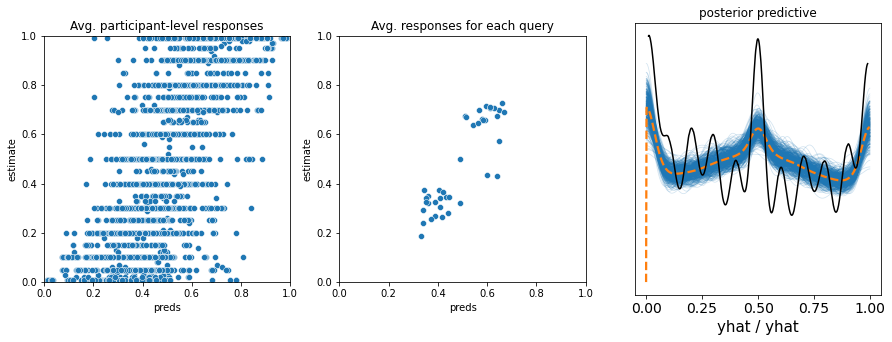

In [30]:
az_data_bs_noise = make_arviz_data(mcmc_bs_noise, bayesian_sampler_complex_mlm_noise, X_data) # see model_helpers.py
# pickle.dump(az_data_bs_noise, open("local/exp2/az_data_bs_noise.p", "wb"))
# pickle.dump(loo_bs, open("local/exp2/loo_bs.p", "wb"))
plot_model_preds(df, az_data_bs_noise)

## Allowing individual noise params to freely vary

In [13]:
def bayesian_sampler_complex_mlm_noise_free(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 

    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
    # k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter
    beta_pop = numpyro.sample("beta_pop", dist.Normal(-2.75, .9)) # skewed after sigmoid
    beta_sd = numpyro.sample("beta_sd", dist.HalfCauchy(1))

    N_prime_pop = numpyro.sample("N_prime_pop", dist.Normal(0,2)) # mildly informative
    N_delta_pop = numpyro.sample("N_delta_pop", dist.Normal(0,2)) 
    N_prime_sd = numpyro.sample("N_prime_sd", dist.HalfCauchy(2))
    N_delta_sd = numpyro.sample("N_delta_sd", dist.HalfCauchy(2))

    # subject-level parameters/priors <--- maybe change to non-centered parameterization for all these
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta_r", dist.Normal(0, beta_sd)) 
        N_deltas = numpyro.sample("N_delta_r", dist.Normal(0, N_delta_sd))
        N_primes = numpyro.sample("N_prime_r", dist.Normal(0, N_prime_sd))
        ks = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter

    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))

    beta = sigmoid(beta_pop + betas[subj])*30 # constrains beta to [0,10]
    #beta = jnp.exp(beta_pop + betas[subj])
    numpyro.deterministic("beta_subj", jnp.exp(beta_pop + betas))

    # exp() needed to constrain N and N_delta positive
    N = 1 + jnp.exp(N_prime_pop + N_primes[subj]) + jnp.exp(N_delta_pop + N_deltas[subj]) * not_conjdisj # they also required N be at least 1

    numpyro.deterministic("N_subj", 1 + jnp.exp(N_prime_pop + N_primes))
    numpyro.deterministic("N_prime_subj", 1 + jnp.exp(N_prime_pop + N_primes) + jnp.exp(N_delta_pop + N_deltas))

    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]

    p_bs = prob_judge_BS(theta, X_num, X_denom, N, beta)
    
    k = ks[subj]

    # Likelihood
    with numpyro.plate("data", len(trial)):
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)

    return yhat




In [14]:
kernel_bs_noise_free = NUTS(bayesian_sampler_complex_mlm_noise_free, target_accept_prob=.80)

mcmc_bs_noise_free = MCMC(kernel_bs_noise_free, 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)

mcmc_bs_noise_free.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [15]:
# mcmc_bs_noise_free.print_summary()

Participant mean response corr =  0.702
Query-level corr 0.871


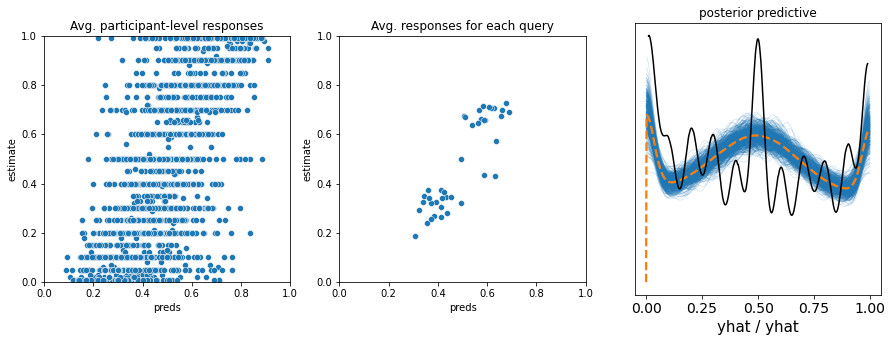

In [16]:
az_data_bs_noise_free = make_arviz_data(mcmc_bs_noise_free, bayesian_sampler_complex_mlm_noise_free, X_data) # see model_helpers.py

plot_model_preds(df, az_data_bs_noise_free)

In [17]:
exp2_model_comparison = az.compare(
    {
        "BS complex mlm": az_data_bs, 
        "BS complex mlm noise": az_data_bs_noise,
        "BS complex mlm noise free": az_data_bs_noise_free,
    }, 
    scale="deviance", ic="loo")

exp2_model_comparison

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:1047: RuntimeWarning: invalid value encountered in true_divide
  len_scale = n * (np.log(-(b_ary / k_ary)) - k_ary - 1)
/opt/conda/

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
BS complex mlm noise free,0,-1359.886875,359.155931,0.000000,0.333333,109.589560,0.000000,True,deviance
BS complex mlm,1,-1043.831949,233.993480,316.054926,0.333333,83.276346,96.767142,True,deviance
BS complex mlm noise,2,NaN,NaN,NaN,0.333333,NaN,NaN,True,deviance


In [19]:
my_azdata = az_data_bs_noise_free

my_azdata.posterior["N_prime"] = np.exp(my_azdata.posterior.N_prime_pop) + np.exp(my_azdata.posterior.N_prime_r)
my_azdata.posterior["N_delta"] = np.exp(my_azdata.posterior.N_delta_pop) + np.exp(my_azdata.posterior.N_delta_r)

def posterior_to_df_1d(az_data, var_name):
    z = az_data.stack(sample=['chain','draw'])
    x = pd.DataFrame(np.array(z.posterior[var_name]))
    z = x.reset_index() >> s.gather("draw", "value", -_.index)
    
    return(z)

def posterior_to_df_2d(az_data, var_name1, var_name2):
    z = az_data.stack(sample=['chain','draw'])
    x1 = pd.DataFrame(np.array(z.posterior[var_name1]))
    x1 = x1.reset_index() >> s.gather("draw", "value1", -_.index)
    
    
    x2 = pd.DataFrame(np.array(z.posterior[var_name2]))
    x2 = x2.reset_index() >> s.gather("draw", "value2", -_.index)
    
    x1["value2"] = x2.value2
    
    return(x1)


def extract_samples(z, var_name):
    x1 = pd.DataFrame(np.array(z.posterior[var_name]))
    x1 = x1.reset_index() >> s.gather("draw", "value", -_.index) >> s.mutate(var = var_name)
    
    return(x1)

def posterior_to_df_multi(az_data, var_list):
    # note variables must have same raw dimensions
    z = az_data.stack(sample=['chain','draw'])
    
    df_list = [extract_samples(z, v) for v in var_list]
    df = pd.concat(df_list)
    
    df = df >> s.spread("var", "value")
    
    return(df)

posterior_to_df_multi(az_data_bs_noise_free, ["k", "N_prime", "N_delta"])

# res

,index,draw,N_delta,N_prime,k
0,0,0,2.968420,0.908560,6.478324
1,0,1,3.639406,1.198351,7.282231
2,0,2,4.108066,1.777010,5.623321
3,0,3,3.957789,0.944332,9.575008
4,0,4,3.005910,1.035363,5.024170
...,...,...,...,...,...
471995,58,7995,2.558376,1.796229,1.140731
471996,58,7996,5.266362,1.637592,1.081827
471997,58,7997,2.510193,1.796693,0.903074
471998,58,7998,2.245122,1.837979,1.018905


/opt/conda/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


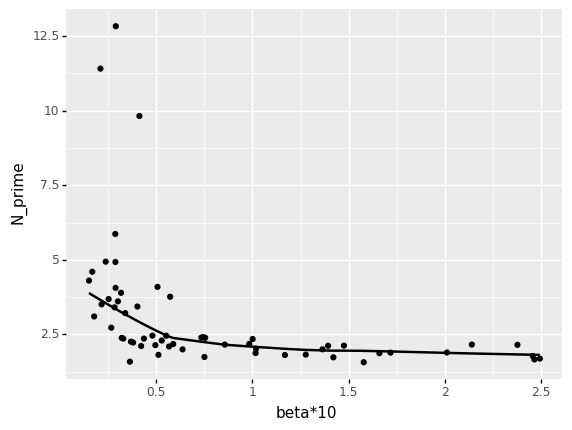

<ggplot: (8737427160872)>

In [53]:
from plotnine import *
my_azdata = az_data_bs_noise_free
my_azdata.posterior["beta"] = my_azdata.posterior.beta_pop + my_azdata.posterior.beta_r


res = (
posterior_to_df_multi(my_azdata, ["beta","k", "N_prime", "N_delta"]) >> 
    s.mutate(N = _.N_prime + _.N_delta, beta = scipy.special.expit(_.beta)) >>
    s.group_by(_.index) >>
    s.summarize(N_prime = _.N_prime.mean(), N = _.N.mean(), k = _.k.mean(), beta = _.beta.mean())
    
)

ggplot(res, aes("beta*10", "N_prime")) + geom_point() + geom_smooth()

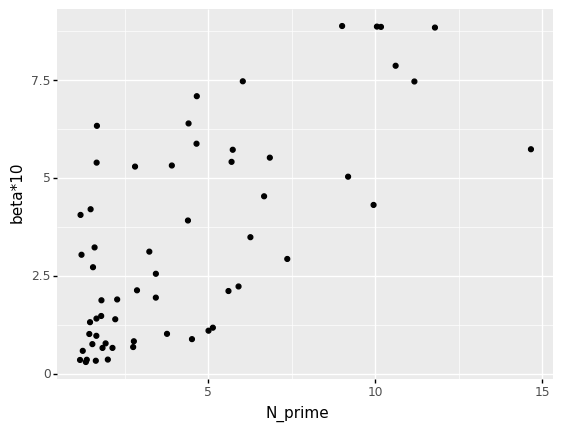

<ggplot: (8737413366128)>

In [25]:
import scipy

my_azdata = az_data_bs_noise

my_azdata.posterior["N_prime"] = np.exp(my_azdata.posterior.N_prime_pop) + np.exp(my_azdata.posterior.N_prime_r)
my_azdata.posterior["N_delta"] = np.exp(my_azdata.posterior.N_delta_pop) + np.exp(my_azdata.posterior.N_delta_r)
my_azdata.posterior["beta"] = my_azdata.posterior.beta_pop + my_azdata.posterior.beta_r

res = (
posterior_to_df_multi(my_azdata, ["beta", "N_prime", "N_delta"]) >> 
    s.mutate(N = _.N_prime + _.N_delta, beta = scipy.special.expit(_.beta)) >>
    s.group_by(_.index) >>
    s.summarize(N_prime = _.N_prime.mean(), N = _.N.mean(), beta = _.beta.mean())
    
)

ggplot(res, aes("N_prime", "beta*10")) + geom_point()

## 6/7/22, 5:20 PM interim conclusions

It's not looking all that good for the Bayesian Sampler model in these distributional regression analyses. Assuming that the number of samples is the noise parameter for the beta regression produces a much worse model. And it looks fairly clear that $k$ and $N$ are more or less uncorrelated when allowed to vary freely. 

The PT+N model assumes no correlation between noise and response noise. So this could argue for a noise-based model like PT+N (but without that model's extra non-Bayesian conditional probability bits). 

After some further explorations with less constrained $\beta$, things are looking less bad for the Bayesian Sampler but still fairly muddled. Now the "noise" model is better than the base model (!) but worse than the freely-varying noise model. And in the freely varying model there is no association between inferred avg samples and k.

In the noise model, $\beta$ and $N$, $N'$ are correlated in a way not predicted by the Bayesian Sampler model, and I'm getting quite large values of $\beta$ that seem outside the spirit of the Bayesian Sampler model. Basically, the high noise levels imply strong priors. 

The high noise levels are (apparently) also a bit of an issue for the PT+N model, as the authors' argued that $d$ values are not ever expected to be near .5.

## Time to implement rounding models

I think rounding may be throwing off the estimate of dispersion (as some of the dispersion is due to rounding), which in turn will affect estimates of $N$ and thus $\beta$. I'm not sure this will make things look better, but seems important to model.

I also need to more carefully think through whether this model is actually right. The BS model says you report the mean of your Beta distribution. So what is the disperion of that? pretty sure it's Beta because it comes from the variance in the binomial sampling, and Beta is like the continuous version of binomial.

i.e. logic is you have a mental model that produces samples with some true rate $\rho$, then from that you get some samples and have an observed fraction $r$ that you integrate with your prior to form a Beta distribution of which you report the mean, which is the response $y$ (ignoring rounding). So it's a beta-binomial-beta model. Except that last beta part is actualy fixed as we imagine people compute and reliably report the mean. So I think when you integrate out the binomial you just get a Beta again. Could simulate it I suppose to sanity-check this (did a quick check and appears yes).

In [87]:
# def binned_probs(mu, k, n_bins):

# dist.Beta(1,1).cdf(.5)

grad_betainc = jax.grad(jax.scipy.special.betainc)

grad_betainc(1.,1.,.2)


# print(jax.__version__)

ValueError: Betainc gradient with respect to a and b not supported.